
# Bidding Value Determination

This Python Notebook aims to determine the bidding values for a free agent based off their previous seasons' performance using PyTorch. By analyzing a player's performance data, we can predict future performance and adjust bidding values accordingly. This approach ensures that bids reflect both historical performance and potential future contributions.



## Data Loading and Preprocessing

First, let's load the data from our CSV files and perform necessary preprocessing steps to prepare it for training with our AI model. We have two key datasets:
- `submission_example.csv`: Contains the list of all free agents.
- `batting_logs.csv`: Contains detailed performance data that we'll use to train our model.

Let's begin by importing the necessary libraries and loading the data.


In [1]:

import pandas as pd

# Load data
free_agents = pd.read_csv('/content/submission_example.csv')
batting_logs = pd.read_csv('/content/batting_season_summary.csv')

print(free_agents.head())
print(batting_logs.head())


              Name  Expected Number of Hits Next Season  Bid Amount($)
0     Aaron Looper                                    1           0.75
1    Adam Peterson                                    1           0.75
2        Adam Wilk                                    1           0.75
3    Adrian Houser                                    1           0.75
4  Agustin Montero                                    1           0.75
                 Name  age      team pos   PA   AB    H  2B  3B  HR  BB   SO  \
0  Abel De Los Santos   25      Cubs  1B  721  676  151  36  28   4  45  170   
1    Adalberto Mendez   28  Phillies  LF  653  623  110  19  18   3  30  104   
2      Adam Greenberg   28   Pirates  RF  579  514  144  29  21  12  65  112   
3       Adam Peterson   21    Braves  1B  742  668  192  45  40  10  74  161   
4        Adam Shabala   34  Mariners  SS  637  600  109  26  12  10  37  143   

       P/PA        BA       OBP       SLG       OPS  Year  
0  3.353675  0.223373  0.271845  


### Feature Selection and Label Definition

Based on our data analysis, we'll use the following columns from `batting_logs.csv` as features to train our AI model:

- Age (`age`)
- Position (`pos`)
- Plate appearances (`PA`)
- At-bats (`AB`)
- Doubles (`2B`)
- Triples (`3B`)
- Home runs (`HR`)
- Walks (`BB`)
- Strikeouts (`SO`)
- Plate appearances per pitch (`P/PA`)
- Batting average (`BA`)
- On-base percentage (`OBP`)
- Slugging percentage (`SLG`)
- On-base plus slugging (`OPS`)

The label for our model will be:
- Hits (`H`): This is a direct measure of a player's offensive success.

Next, we will encode categorical variables, normalize numerical values, and split the dataset into training and validation sets.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Selecting features and label
features = batting_logs[['age', 'pos', 'PA', 'AB', '2B', '3B', 'HR', 'BB', 'SO', 'P/PA', 'BA', 'OBP', 'SLG', 'OPS']]
label = batting_logs['H']

# Defining preprocessing steps
categorical_features = ['pos']
numerical_features = ['age', 'PA', 'AB', '2B', '3B', 'HR', 'BB', 'SO', 'P/PA', 'BA', 'OBP', 'SLG', 'OPS']

# Create preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, label, test_size=0.2, random_state=42)

# Apply transformations
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)



## Model Definition

For our bidding value determination model, we'll use a simple neural network architecture since our dataset might not be overly complex. PyTorch will be used for defining and training the model. The model will consist of several fully connected layers with ReLU activation functions, and a final layer suited to regression since we're predicting a continuous value (the number of hits).


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class BiddingValueNet(nn.Module):
    def __init__(self, num_features):
        super(BiddingValueNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1) # Output layer for regression

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Determine the number of features after preprocessing
num_features = X_train.shape[1]

# Initialize the model
model = BiddingValueNet(num_features)



## Training the Model

Now, let's train our model. We'll use Mean Squared Error (MSE) as the loss function since this is a regression problem, and the Adam optimizer for its efficiency.


In [58]:
import numpy as np

# Training parameters
learning_rate = 0.001
epochs = 1000

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Convert numpy arrays to torch tensors
X_train_torch = torch.tensor(X_train.astype(np.float32))
y_train_torch = torch.tensor(y_train.values.astype(np.float32))
X_val_torch = torch.tensor(X_val.astype(np.float32))
y_val_torch = torch.tensor(y_val.values.astype(np.float32))

# Training loop
for epoch in range(epochs):
    # Forward pass: compute predicted y by passing x to the model
    y_pred = model(X_train_torch)

    # Compute and print loss
    loss = criterion(y_pred, y_train_torch.view(-1, 1))
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch [10/1000], Loss: 5.9479
Epoch [20/1000], Loss: 2.3657
Epoch [30/1000], Loss: 0.8810
Epoch [40/1000], Loss: 0.6127
Epoch [50/1000], Loss: 0.5592
Epoch [60/1000], Loss: 0.5230
Epoch [70/1000], Loss: 0.4865
Epoch [80/1000], Loss: 0.4661
Epoch [90/1000], Loss: 0.4559
Epoch [100/1000], Loss: 0.4429
Epoch [110/1000], Loss: 0.4317
Epoch [120/1000], Loss: 0.4202
Epoch [130/1000], Loss: 0.4091
Epoch [140/1000], Loss: 0.3982
Epoch [150/1000], Loss: 0.3874
Epoch [160/1000], Loss: 0.3769
Epoch [170/1000], Loss: 0.3667
Epoch [180/1000], Loss: 0.3568
Epoch [190/1000], Loss: 0.3470
Epoch [200/1000], Loss: 0.3375
Epoch [210/1000], Loss: 0.3281
Epoch [220/1000], Loss: 0.3190
Epoch [230/1000], Loss: 0.3102
Epoch [240/1000], Loss: 0.3016
Epoch [250/1000], Loss: 0.2932
Epoch [260/1000], Loss: 0.2850
Epoch [270/1000], Loss: 0.2769
Epoch [280/1000], Loss: 0.2691
Epoch [290/1000], Loss: 0.2616
Epoch [300/1000], Loss: 0.2544
Epoch [310/1000], Loss: 0.2475
Epoch [320/1000], Loss: 0.2409
Epoch [330/1000],

In [59]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val_torch)
    val_loss = criterion(y_pred_val, y_val_torch.view(-1, 1))
    print(f'Validation Loss: {val_loss.item():.4f}')


Validation Loss: 0.2348


In [60]:
import matplotlib.pyplot as plt

def predict_second_half(player_name, model, preprocessor, num_features):
    # Fetch player's historical data
    player_data = batting_logs[batting_logs['Name'] == player_name]

    if player_data.empty:
        print("Player not found in the dataset.")
        return None

    # Check if the player has enough data
    if len(player_data) < 3:
        print(f"Player {player_name} does not have enough data to make reliable predictions.")
        return None


    # Split the data into first and second half of the career
    mid_point = len(player_data) // 2
    first_half = player_data.iloc[:]
    second_half = player_data.iloc[mid_point:]

    # Predict hits for the second half using the first half data
    first_half_years = first_half['Year'].values
    first_half_hits = first_half['H'].values
    second_half_years = second_half['Year'].values
    predicted_second_half_hits = []

    for _, row in second_half.iterrows():
        # Select the current year's data
        current_year_data = row.to_frame().T

        # Preprocess the current year's data
        current_year_data_preprocessed = preprocessor.transform(current_year_data[['age', 'pos', 'PA', 'AB', '2B', '3B', 'HR', 'BB', 'SO', 'P/PA', 'BA', 'OBP', 'SLG', 'OPS']])

        # Check if the preprocessing results in the expected number of features
        if current_year_data_preprocessed.shape[1] != num_features:
            print("Unexpected number of features after preprocessing.")
            return None

        # Convert to torch tensor
        current_year_data_tensor = torch.tensor(current_year_data_preprocessed.astype(np.float32))

        # Predict
        model.eval()
        with torch.no_grad():
            predicted_hits = model(current_year_data_tensor).item()

        predicted_second_half_hits.append(predicted_hits)

    # Plot the actual and predicted hits
    plt.figure(figsize=(12, 6))
    plt.plot(first_half_years, first_half_hits, label='First Half (Actual)')
    plt.plot(second_half_years, predicted_second_half_hits, label='Second Half (Predicted)')
    plt.xlabel('Year')
    plt.ylabel('Hits')
    plt.title(f'{player_name} - Career Hits')
    plt.legend()
    plt.show()

In [61]:
def predict_next_year(player_name, model, preprocessor, num_features):
    # Fetch player's historical data
    player_data = batting_logs[batting_logs['Name'] == player_name]

    if player_data.empty:
        print("Player not found in the dataset.")
        return None

    # Select the most recent year of data
    player_data_latest = player_data[player_data['Year'] == player_data['Year'].max()]

    # Preprocess the data
    features = player_data_latest[['age', 'pos', 'PA', 'AB', '2B', '3B', 'HR', 'BB', 'SO', 'P/PA', 'BA', 'OBP', 'SLG', 'OPS']]
    features_preprocessed = preprocessor.transform(features)

    # Check if the preprocessing results in the expected number of features
    if features_preprocessed.shape[1] != num_features:
        print("Unexpected number of features after preprocessing.")
        return None

    # Convert to torch tensor
    features_tensor = torch.tensor(features_preprocessed.astype(np.float32))

    # Predict
    model.eval()
    with torch.no_grad():
        predicted_hits = model(features_tensor).item()

    return predicted_hits

In [63]:
# Individual player
player_name = "Aaron Looper"
next_year_hits = predict_next_year(player_name, model, preprocessor, num_features)
print(f"Estimated number of hits for {player_name} next year: {next_year_hits:.0f}")

# # All players
# for free_agent in free_agents['Name']:
#   next_year_hits = predict_next_year(player_name, model, preprocessor, num_features)
#   print(f"Estimated number of hits for {player_name} next year: {next_year_hits:.0}")

Estimated number of hits for Aaron Looper next year: 157


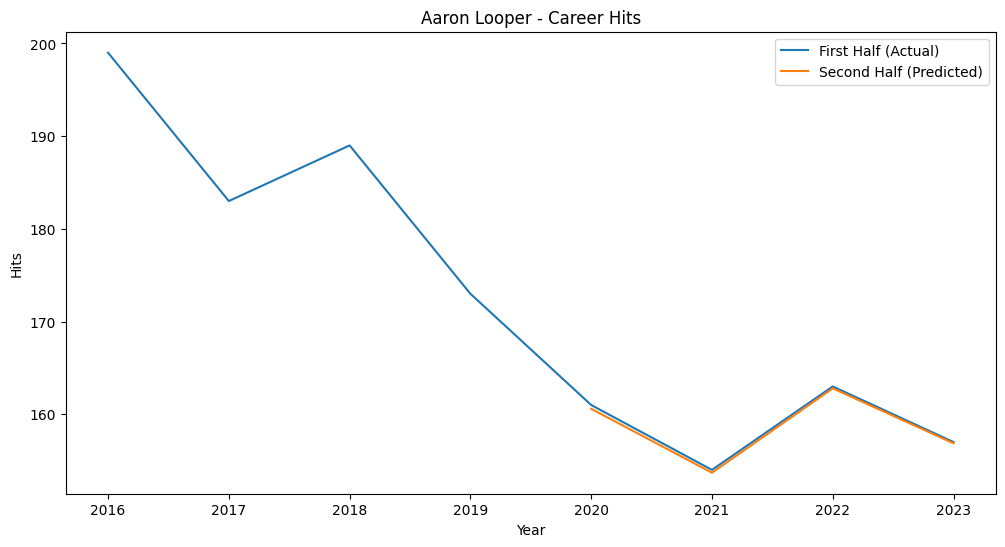

In [64]:
# Individual player
player_name = "Aaron Looper"
predict_second_half(player_name, model, preprocessor, num_features)

# # All players
# for free_agent in free_agents['Name']:
#   predict_second_half(free_agent, model, preprocessor, num_features)

In [55]:
import csv

headers = ["Name", "Expected Number of Hits Next Season", "Bid Amount($)"]

with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)

    for player_name in free_agents['Name']:
        next_year_hits = predict_next_year(player_name, model, preprocessor, num_features)
        row = [player_name, f"{next_year_hits:.0f}", 0.00]
        writer.writerow(row)